In [118]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt

In [128]:
api_key=''

In [120]:
def query(sql, **kw):
    response = requests.get('https://joinzoe.carto.com/api/v2/sql/', params={
        'q':sql,
        'api_key':api_key
    })
    data = response.json()
    if 'error' in data:
        return data['error']
    return pd.DataFrame.from_records(data['rows'], **kw)

In [121]:
def pickle(df, name, for_date):
    path = f'~/Downloads/zoe_{name}_{for_date:%Y-%m-%d}_{datetime.now():%Y-%m-%d-%H-%M}.pickle'
    df.to_pickle(path)
    return path

In [122]:
tables = query("SELECT * FROM pg_catalog.pg_tables where tableowner!='postgres' order by tablename")
tables

['system tables are forbidden']

In [145]:
uk_time_series = query("SELECT * FROM uk_time_series_cases", index='date')
uk_time_series.index = pd.to_datetime(uk_time_series.index)

In [ ]:
pickle(uk_time_series, 'uk_time_series', uk_time_series.index.max())

In [140]:
uk_time_series[-10:]

,cartodb_id,the_geom,the_geom_webmercator,field_1,corrected_covid_positive
date,,,,,
2020-05-28 00:00:00+00:00,61,None,None,304,0.199105
2020-05-29 00:00:00+00:00,62,None,None,309,0.186581
2020-05-30 00:00:00+00:00,63,None,None,314,0.182066
2020-05-31 00:00:00+00:00,64,None,None,319,0.173879
2020-06-01 00:00:00+00:00,65,None,None,324,0.169650
2020-06-02 00:00:00+00:00,66,None,None,329,0.162868
2020-06-03 00:00:00+00:00,67,None,None,334,0.161458
2020-06-04 00:00:00+00:00,68,None,None,339,0.162652
2020-06-05 00:00:00+00:00,69,None,None,344,0.166407


Text(0, 0.5, 'Predicted # of cases')

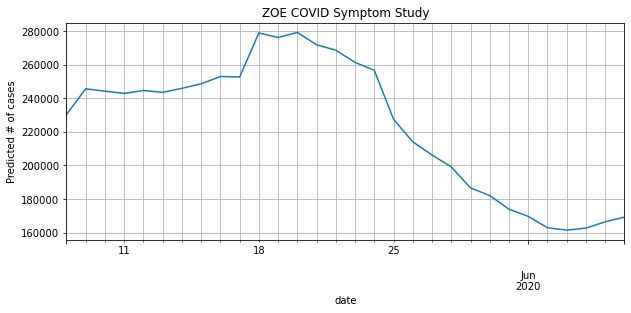

In [144]:
month_ago = datetime.now().date()-timedelta(days=30)
ax = (uk_time_series['corrected_covid_positive']*1000000)[month_ago:].plot(grid=True, figsize=(10,4))
ax.set_title('ZOE COVID Symptom Study')
ax.xaxis.grid(True, which='minor')
ax.set_ylabel('Predicted # of cases')

In [ ]:
final_map = query("SELECT * FROM final_map")
final_map

In [ ]:
for_date, = final_map['data_status'].unique()
pickle(final_map, 'final_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y'))

In [196]:
final_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cartodb_id                      391 non-null    int64  
 1   the_geom                        391 non-null    object 
 2   the_geom_webmercator            391 non-null    object 
 3   objectid                        391 non-null    int64  
 4   lad16cd                         391 non-null    object 
 5   lad16nm                         391 non-null    object 
 6   lad16nmw                        22 non-null     object 
 7   bng_e                           391 non-null    int64  
 8   bng_n                           391 non-null    int64  
 9   long                            391 non-null    float64
 10  lat                             391 non-null    float64
 11  st_areasha                      391 non-null    float64
 12  st_lengths                      391 

In [131]:
final_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
31,Barrow-in-Furness,E07000027,1.138894
316,Tameside,E08000008,1.136650
75,Kettering,E07000153,1.134895
122,Doncaster,E08000017,1.057760
4,Blackpool,E06000009,1.056895
173,Halton,E06000006,1.055714
177,"Kingston upon Hull, City of",E06000010,1.031613
309,Coventry,E08000026,1.022229
47,Rochford,E07000075,0.983535
255,Hyndburn,E07000120,0.981790


In [132]:
import geopandas
import shapely
from geopandas import GeoDataFrame
import glob
from pathlib import Path
from dateutil.parser import parse as parse_date

In [133]:
def convert_df(df, geom_col):
    geoms = df[geom_col]
    df[geom_col] = geoms = geoms.apply(lambda x: shapely.wkb.loads(str(x), hex=True))
    crs = "epsg:{}".format(shapely.geos.lgeos.GEOSGetSRID(geoms.iat[0]._geom))
    return GeoDataFrame(df, crs=crs, geometry=geom_col)

Text(0.5, 1.0, 'ZOE COVID Symptom Study data for 06 Jun 2020')

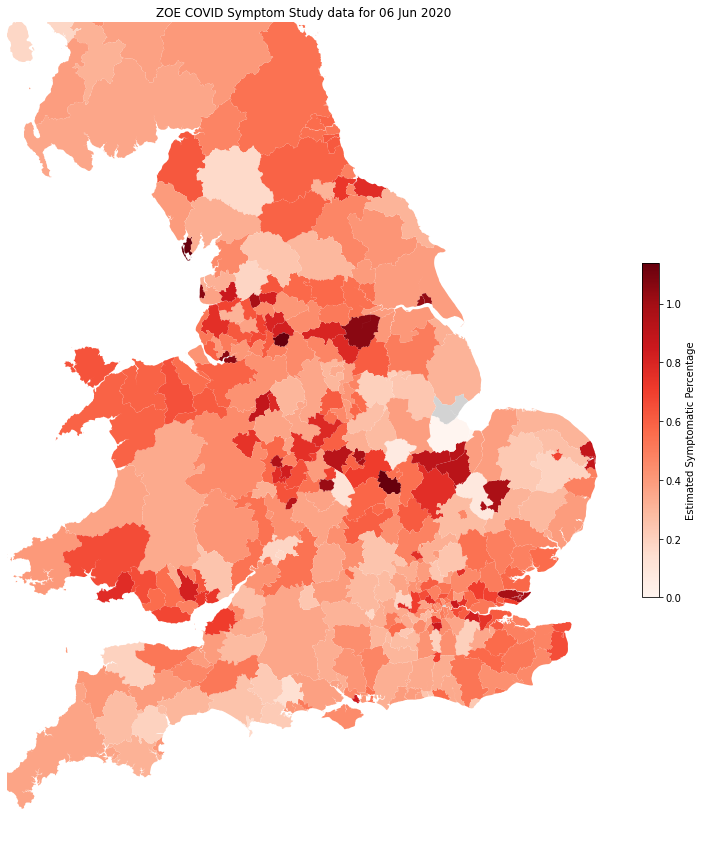

In [134]:
path = sorted(Path('~/Downloads/').expanduser().glob(f'zoe_final_map_*.pickle'), reverse=True)[0]
date = parse_date(str(path).rsplit('_')[-2]).date()
df = pd.read_pickle(path)
gdf = convert_df(df, 'the_geom_webmercator')
ax = gdf.plot(
    column='percentage', 
    k=10, figsize=(15, 15), 
    cmap='Reds', 
    legend=True, 
    legend_kwds={'fraction': 0.02, 'anchor': (0, 0), 'label': 'Estimated Symptomatic Percentage'},
    missing_kwds={'color': 'lightgrey'},
)
ax.set_axis_off()

# ignore shetlands, no data anyway
ax.set_ylim(6400000, 8200000)

# south of england:
#ax.set_ylim(6500000, 6850000)
#ax.set_xlim(-400000,  100000)

# england
ax.set_ylim(6400000, 7500000)
ax.set_xlim(-600000,  200000)


ax.set_title(f'ZOE COVID Symptom Study data for {date:%d %b %Y}')

In [116]:
geoms = gdf[['lad16cd', 'the_geom_webmercator']]
geoms.set_index('lad16cd', inplace=True)
geoms.to_pickle('~/Downloads/geoms_lad16cd.pickle')